<a href="https://colab.research.google.com/github/Gulshan979/Amazon-Fine-Food-Reviews-Classification/blob/main/Lung_cancer_Detection_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import kagglehub
paultimothymooney_chest_xray_pneumonia_path = kagglehub.dataset_download('paultimothymooney/chest-xray-pneumonia')

print('Data source import complete.')


Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

Streaming output truncated to the last 5000 lines.
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person629_bacteria_2509.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person952_bacteria_2877.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1315_virus_2270.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1392_bacteria_3538.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person475_bacteria_2025.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1288_bacteria_3251.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1005_virus_1688.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person442_virus_900.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person755_bacteria_2659.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person655_bacteria_2547.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

In [4]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([np.array(resized_arr), class_num]) # Ensure appending NumPy arrays
            except Exception as e:
                print(e)
    return np.array(data, dtype=object) # Use dtype=object to allow for potentially varying shapes if necessary

In [5]:
train = get_training_data('/kaggle/input/chest-xray-pneumonia/chest_xray/train')
test = get_training_data('/kaggle/input/chest-xray-pneumonia/chest_xray/test')
val = get_training_data('/kaggle/input/chest-xray-pneumonia/chest_xray/val')

<Axes: xlabel='count'>

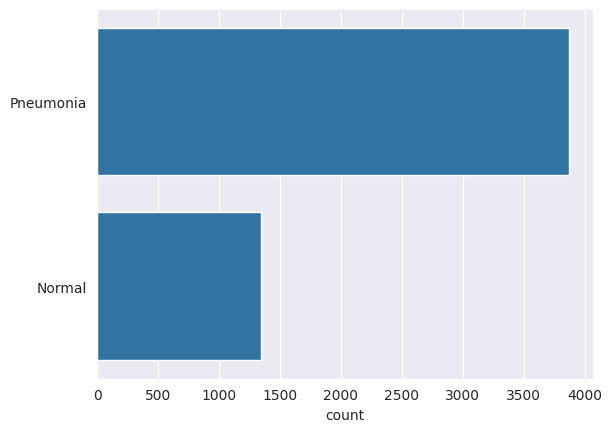

In [6]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)

Text(0.5, 1.0, 'NORMAL')

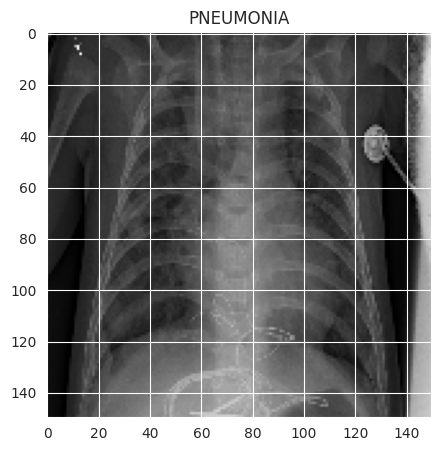

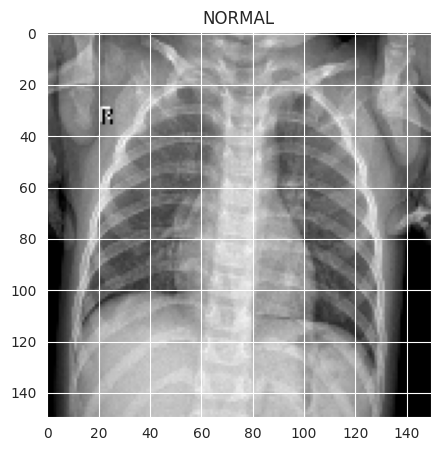

In [7]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [8]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [9]:
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [10]:
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [11]:
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range = 30,
        zoom_range = 0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip = True,
        vertical_flip=False)


datagen.fit(x_train)

For the data augmentation, i choosed to :
1. Randomly rotate some training images by 30 degrees
2. Randomly Zoom by 20% some training images
3. Randomly shift images horizontally by 10% of the width
4. Randomly shift images vertically by 10% of the height
5. Randomly flip images horizontally.
Once our model is ready, we fit the training dataset.

In [12]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 38, 38, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 38, 38, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 19, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 19, 19, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 1,246,401 (4.75 MB)

 Trainable params: 1,245,313 (4.75 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [13]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [14]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7911 - loss: 1.1135

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 24s 81ms/step - accuracy: 0.7914 - loss: 1.1101 - val_accuracy: 0.5000 - val_loss: 55.7184 - learning_rate: 0.0010
Epoch 2/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 32s 73ms/step - accuracy: 0.8791 - loss: 0.2724 - val_accuracy: 0.5000 - val_loss: 36.6102 - learning_rate: 0.0010
Epoch 3/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9133 - loss: 0.2326
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 94ms/step - accuracy: 0.9133 - loss: 0.2325 - val_accuracy: 0.5000 - val_loss: 32.7828 - learning_rate: 0.0010
Epoch 4/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 12s 72ms/step - accuracy: 0.9412 - loss: 0.1594 - val_accuracy: 0.5000 - val_loss: 30.5836 - learning_rate: 3.0000e-04
Epoch 5/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9364 - loss: 0.1784
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
163/163 ━━━━━━━━━━━━━━━━━━━━ 12s 72ms/step - accuracy: 0.9365 - loss: 0.

In [15]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9139 - loss: 0.2195
Loss of the model is -  0.2367338091135025
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9139 - loss: 0.2195
Accuracy of the model is -  90.86538553237915 %


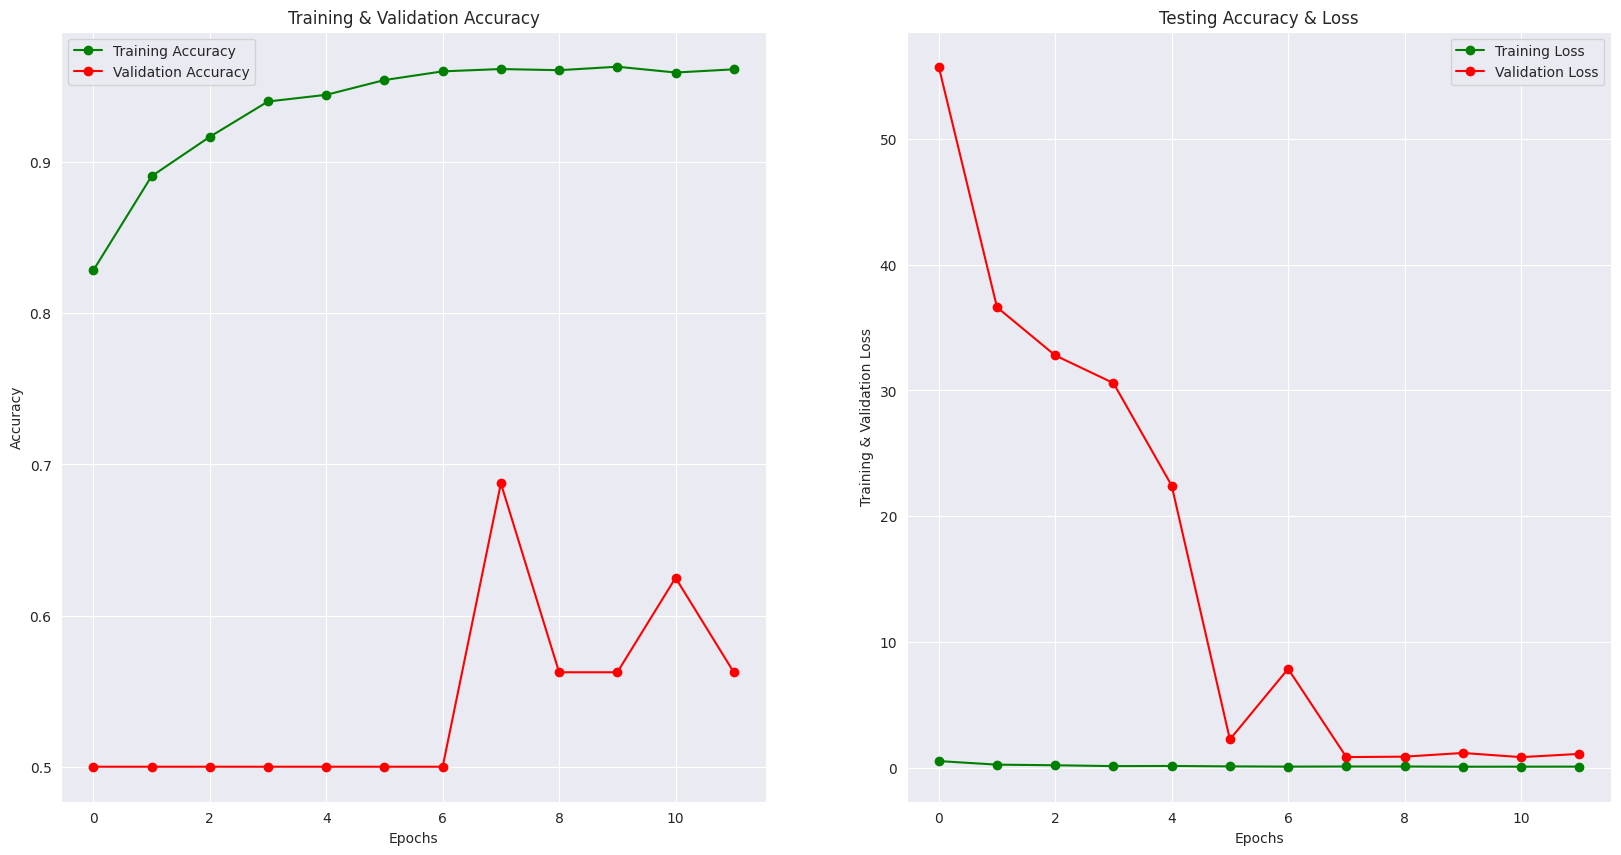

In [16]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [18]:
predictions = model.predict(x_test)
predictions = (predictions > 0.5).astype(int).reshape(1,-1)[0]
predictions[:15]

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0])

In [19]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.92      0.93      0.93       390
   Normal (Class 1)       0.88      0.87      0.88       234

           accuracy                           0.91       624
          macro avg       0.90      0.90      0.90       624
       weighted avg       0.91      0.91      0.91       624



In [20]:
cm = confusion_matrix(y_test,predictions)
cm

array([[363,  27],
       [ 30, 204]])

In [21]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

In [22]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

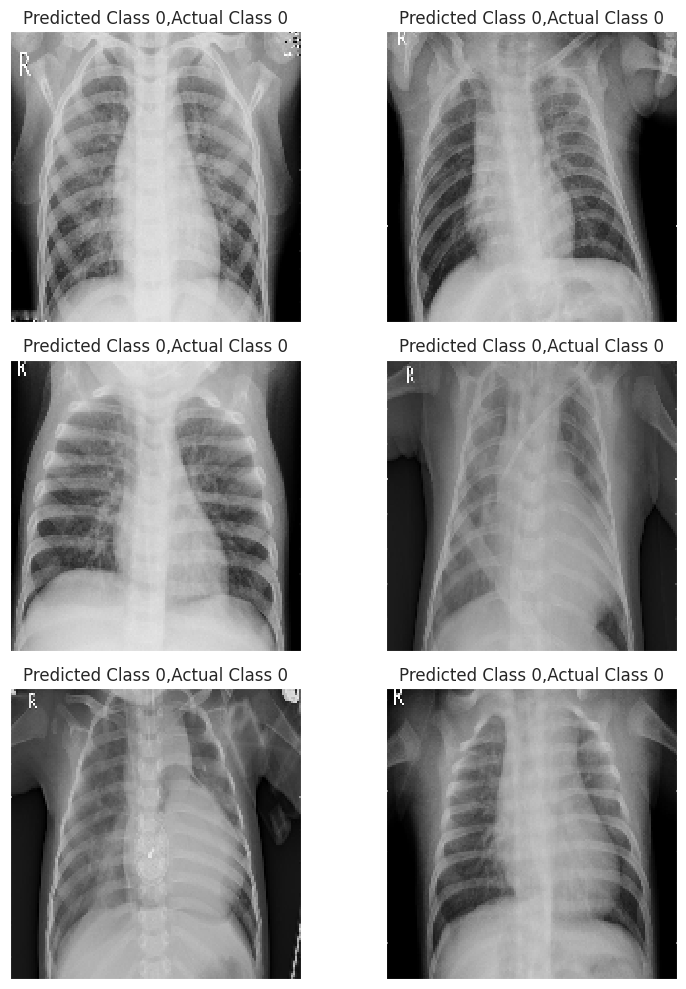

In [27]:
i = 0
plt.figure(figsize=(10,10)) # Increase figure size
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1
plt.show() # Add plt.show() to display the figure

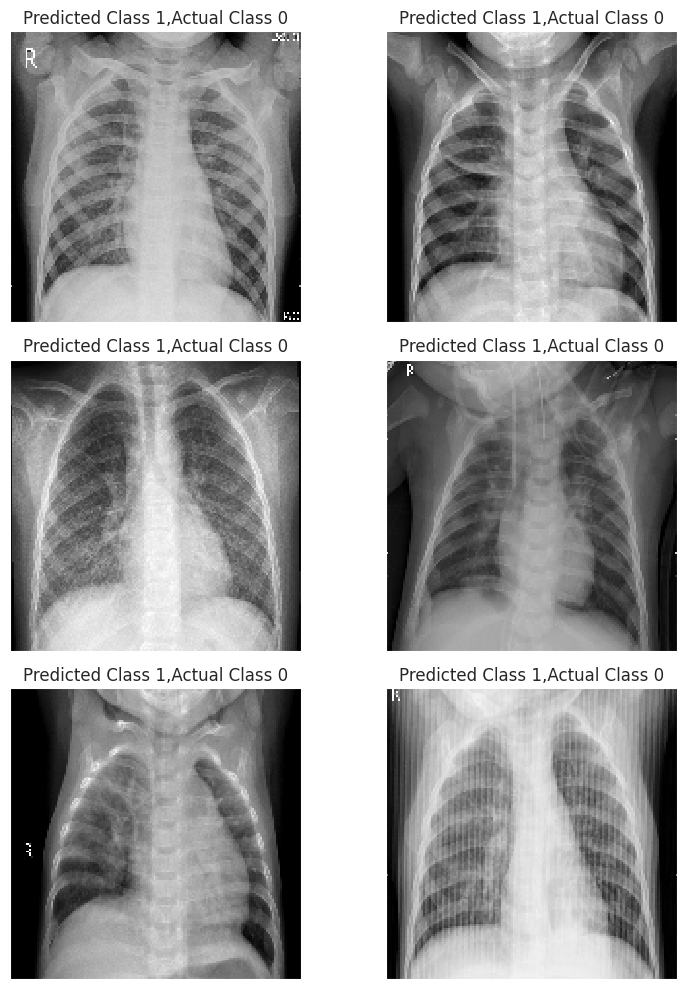

In [28]:
i = 0
plt.figure(figsize=(10,10)) # Increase figure size
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1
plt.show() # Add plt.show() to display the figure

the process of building, training, and evaluating a CNN model for the task of classifying chest X-ray images as either normal or indicative of **pneumonia**